## Introduction to Craters on Planetary Surfaces

Cratering is an important process that has altered the surface topography of the Earth, other terrestrial and icy planets, and both rocky and icy moons, within our solar system and probaby others. That is - cratering is quite a uniform process. However, although we understand the process of cratering quite well, we only have a limited understanding about how a cratered surface influences the role of other surface processes. For example, on heavily cratered surfaces of the Moon, Mars, and Mercury, which have not been altered by plate tectonics like on Earth, how do the craters affect the flow and collection of water? of wind? and of the sediments transported by water and wind? These are funamental questions in our understanding of planetary bodies. Looking at the surfaces of the 4 rocky planets in our solar system, Earth is the odd one out, with topography dominated by mountains and basins created by plate tectonics. Based on this knowledge, what do you expect other planetary surfaces in other solar systems would look like, cratered or Earth-like? 


#### Learning objectives
_Skills_
* Use of LandLab model grids and components to route any kind of flow over the model surface
* Make changes to input parameters to vary the number and sizes of craters 
* Gain hands-on experience with visualizing data in Python

_Key concepts_
* Explore and understand the process of simulation of craters on a landscape
* Explore how an initially cratered landscape is affected by hillslope diffusion and the flow of surface water




In this notebook, we also use a LandLab model grid to simulate topography, you can see more about LandLab here: (link)

In [9]:
import numpy as np
from landlab import RasterModelGrid, imshow_grid, NodeStatus, values
import random as random
import matplotlib.pyplot as plt

## How do we simulate crater location and size?

The size and location of a crater is somewhat random, but to constrain it in numerical models, we "pick" numbers randomly from a given probability distribution.   

#### Randomly Selecting Crater Locations

In this model, we pick crater loctions randomly from a  "uniform" distribution, that is, each location has an equally probable chance of having a crater. For example, in the code below we pick an x-coordinate and y-coordinate at random from a uniform distribution using the numpy.random.randint function which generates a random integer from a given minimum to a given maximum:

In [10]:
cratercenter = (np.random.randint(1, 10), np.random.randint(1, 10))
print("(x, y) = ", cratercenter)

(x, y) =  (8, 9)


If we generate many crater centers and plot the x and y coordinates as a histogram you can see there are _roughly_ equal numbers of each number

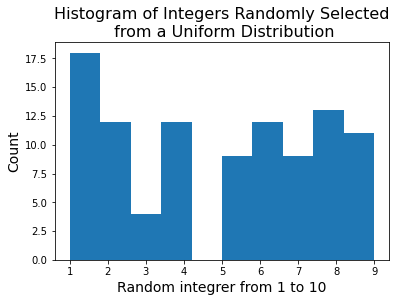

In [17]:
cratercenters = [np.random.randint(1, 10) for i in range(100)]

plt.hist(cratercenters);
plt.xlabel("Random integrer from 1 to 10", fontsize = 14);
plt.ylabel("Count", fontsize = 14);
plt.title("Histogram of Integers Randomly Selected\n from a Uniform Distribution", fontsize = 16);

#### Randomly Selecting Crater Diameters

For crater size, we do not choose from a random distribution because there are actually different probabilities for different crater sizes. 
* Larger meteorites are less common, and more likely to break up in the atmosphere, so they are less likely to create craters at the surface. 
* Medium to Small meteorites are more common and correspondingly so are their craters, 
* but very small meteorites, although very common, are not likely to make it to the surface as they burn up in the atmosphere - even if it is incredibly thin like on Mars. 

Here we ignore very small craters (<1 km) as in a landscape evolution model we would likely be looking at medium to large scales (>> 1 km), and this simplifies the probability distribution to a **cumulative probability distribtuion** (Figure). Where the number of craters, ND, of diameter, D, that form is related to two scaling factors, Kx and an exponent $ \delta $:

$ N_D = K_x    D^{- \delta} $  

For Mars it has been estimated that: 

$ K_x $ = 1.0

and

$ \delta $ = 2.0 

In reality we implement this as shown in the code below, by using the "number of craters of a given diameter (Nd)" as a probability weight for that diameter, and we select the crater diameter randomly from a probability distribution of how many of that given diameter's craters there should be 

In [ ]:
Kx = 1.0  # Scaling coefficient
delta = 2.0  # km, scaling exponent
# Ncraters = 2 # Number of craters to add

minD = 1 #1 km
maxD =  50 # 50 km

diameter = list(range(minD, maxD)) ## make a list of all the possible diameters, from minD to maxD

NumberDs = [] #This step is required before the loop to instantiate a list which will hold our output
for D in range(minD, maxD): #for each diameter from 1 km to 50 km
    NumberD = Kx * D ** - delta #calculate the number of craters of that diameter that there should be
    NumberDs.append(NumberD) #append the number to a list of all the "numbers" of craters for each diameter, from 1 to 50 km
    

def weighted_choice_sub(weights):
    ''' randomly generate a number and see which weight number in the input list it falls under,
    return the index of that weight '''
    rnd = np.random.random() * sum(weights)
    for i, w in enumerate(weights):
        rnd -= w
        if rnd < 0:
            return i #return the index of the weight, which corresponds to the index of the diameter in a "partner" list


D_index = weighted_choice_sub(NumberDs)
print(diameter[D_index])

If we generate many crater diameters and plot them as a histogram you can see there are more small craters and the number of craters of larger and larger diameters decreases, but this is not a perfect fit as there is some "noise" as we **_randomly_** selected from this distribution

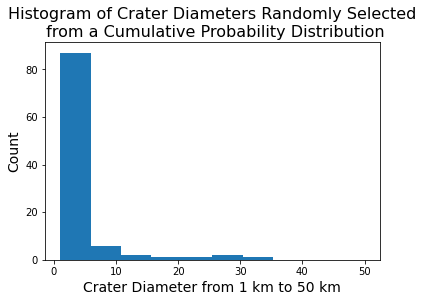

In [33]:
craterdiameters = [diameter[weighted_choice_sub(NumberDs)] for i in range(100)]

plt.hist(craterdiameters, bins = 10, range = (minD, maxD));
plt.xlabel("Crater Diameter from {} km to {} km".format(minD, maxD), fontsize = 14);
plt.ylabel("Count", fontsize = 14);
plt.title("Histogram of Crater Diameters Randomly Selected\n from a Cumulative Probability Distribution", fontsize = 16);

## How do we simulate crater shape? 

Good question! 

Craters are recognized because of the characteristic bowl-like depression that transitions upwards into a crater rim, that is actually above the surrounding terrain and surrounded by an "ejecta blanket" of all the material excavated from the crater itself, and with distance away from the crater the rim slopes downwards and the ejecta blanket gets thinner, so their contributions to elevation get smaller and smaller. These changes in elevation can actually be described by mathematical equations such as an exponential function, or in our case, a power law. 

For a SIMPLE crater (bowl-like depression) with diameter, D, on Mars, the elevation changes are:

$ H2 - H1 + H1 \frac{2r}{D}^{m} $ within the crater (ie. from radial distance = 0 to radial distance = crater radius) (1)

$ H2 \frac{2r}{D}^{-n} $ outside of the crater (ie. where radial distance > crater radius, to describe the ejecta blanket) (2) 


and where $ r $ is the radial distance from the crater center, and $ H1, H2, $ and the exponents $ m $ and $ n $ are:

$ H1 = 2.54 D ^{0.67} $

$  H2 = 1.93 D ^{0.52} $
  
$  m = 0.73 D ^{0.11} $ 

$ n  = 3 $


These equations can be modified slightly to reflect the shape of a Complex crater, although they still do not describe finer crater detail such a central uplift and terracing, which is usually not considered as part of landscape-scale simulations. 

Text(0.5, 1.0, 'Complex Crater')

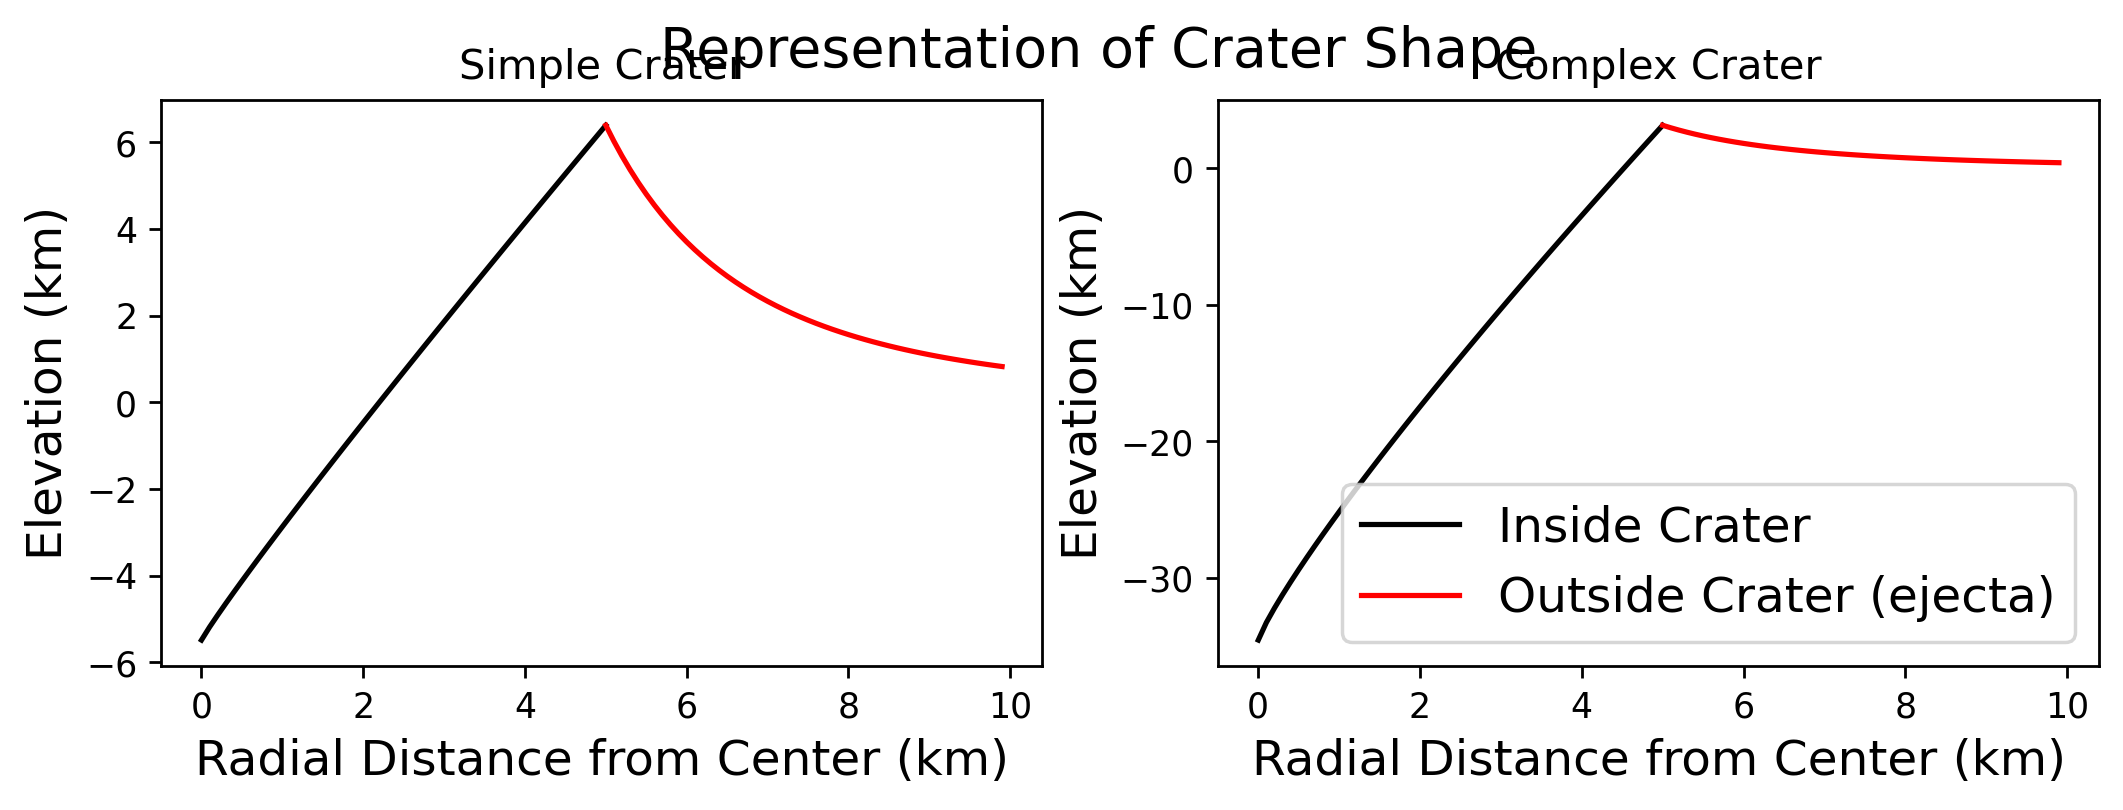

In [66]:
diameter = 10 #km
radius = diameter/2

H1 = 2.54*diameter**0.67
H2 = 1.93*diameter**0.52
m = 0.73*diameter**0.11 
n = 3

rs = np.arange(start=0, stop=diameter, step=0.1) #create an array of radial distances from the crater center


incrater = rs[rs <= radius]
in_idx = np.where(rs <= radius)[0]
# equation for inside the crater
inDepth = H2 - H1 + H1*((2*incrater)/(diameter))**m
# mg.at_node['topographic__elevation'][in_idx] += inDepth

outcrater = rs[rs >= radius]
out_idx = np.where(rs >= radius)[0]
# equation for outside the crater (ejecta!)
outDepth = H2*((2*outcrater)/(diameter))**-n
# mg.at_node['topographic__elevation'][out_idx] += outDepth


fig, ax = plt.subplots(1, 2, dpi=250, facecolor='w', figsize=(10, 3))
fig.suptitle("Representation of Crater Shape", fontsize = 16);
ax[0].plot(incrater, inDepth, 'k', label = 'Inside Crater');
ax[0].plot(outcrater, outDepth, 'r', label = 'Outside Crater (ejecta)');
ax[0].set_xlabel("Radial Distance from Center (km)", fontsize = 14);
ax[0].set_ylabel("Elevation (km)", fontsize =14 );
# ax[0].legend(loc="best", fontsize=14)
ax[0].set_title("Simple Crater")


## Lets also compare the shape of a complex crater! (for simplicity; the crater is of the same diameter as the one above)
H1 = 12.20*diameter**0.49
H2 = 0.79*diameter**0.6
m = 0.64*diameter**0.13 
n = 3

# equation for inside the crater
inDepthC = H2 - H1 + H1*((2*incrater)/(diameter))**m
# mg.at_node['topographic__elevation'][in_idx] += inDepth

# equation for outside the crater (ejecta!)
outDepthC = H2*((2*outcrater)/(diameter))**-n
# mg.at_node['topographic__elevation'][out_idx] += outDepth


ax[1].plot(incrater, inDepthC, 'k', label = 'Inside Crater');
ax[1].plot(outcrater, outDepthC, 'r', label = 'Outside Crater (ejecta)');
ax[1].set_xlabel("Radial Distance from Center (km)", fontsize = 14);
ax[1].set_ylabel("Elevation (km)", fontsize =14 );
ax[1].legend(loc="best", fontsize=14)
ax[1].set_title("Complex Crater")

## Now with all of the cratering theory covered, let's make a cratered surface!

This tutorial uses LandLabs model grids, a convenient library of modules for building model grids, with many components to then do landscape evolution on the grids! With some tweaks to the code, this cratering module would work just as well on a numpy array of elevation values. 

First, lets instantiate the LandLab model grid, with a field for elevation values called "topographic__elevation":

In [97]:
size = 200
spacing = 1
rf = 10

mg = RasterModelGrid((xy,xy), xy_spacing = spacing); #initiate surface; see above for variables
z = mg.add_zeros('topographic__elevation', at='node') #create an array of zeros for each node of the model grid

We can add some random noise to this surface to make it slightly more realistic. The "seed" here ensures that the added-randomness is the same everytime, to keep our model grid reproducible! 

In [98]:
np.random.seed(30) # Keep this constant (e.g., at 30) so the initial randomness it always the same
z += np.random.rand(mg.number_of_nodes)  # make the noise large enough relative to crater
mg.at_node["topographic__elevation"] *= rf 

It's very easy to visualize model grids with the inbuilt function, imshow

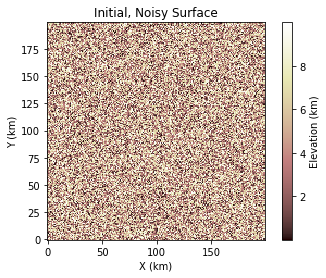

In [99]:
imshow_grid(mg, "topographic__elevation" , plot_name='Initial, Noisy Surface',
        var_name='Elevation', var_units='km', grid_units=('km', 'km')) #imshow(grid, value field)

### ADD SOME CRATERS!

How many craters do you want to add per timestep? 100
Minimum possible crater size: 3 km
Maximum possible crater size: 50 km


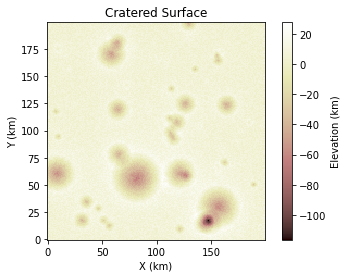

In [101]:
Ncraters = int(input("How many craters do you want to add per timestep? ")) # see console to add your own number!

minD = int(spacing * 3) # want it to be greater than spacing, three times the smallest cell
print("Minimum possible crater size:", minD, "km")
maxD = int((size)/4) #max diameter (m), a quarter of the total domain width
print("Maximum possible crater size:", maxD, "km")

NDs = []
for D in range(minD, maxD):
    ND = Kx * D ** - delta
    NDs.append(ND)

## Everything is packaged as functions: 
def crater_depth(d, diameter, mg, d_ref=7):
    """
    Define in and out of crater changes to topography.

    Parameters
    ----------
    d : np.ndarray
        Array of distances of nodes to the center of the crater.
        From `landlab.grid.raster.RasterModelGrid.calc_distances_of_nodes_to_point`
    diameter : int, float
        Diameter of the crater
    mg : landlab.grid.raster.RasterModelGrid
        Landlab raster model grid of the landscape

    d_ref: int, float
        Diameter at which craters transition from "simple" to "complex" structural type
        Default = 7 km (relevant to Mars)

    Returns
    -------
    mg : landlab.grid.raster.RasterModelGrid
        Landlab raster model grid after crater has modified the topography
    """
    radius = diameter / 2

    if diameter <= d_ref:
        H1 = 2.54*diameter**0.67
        H2 = 1.93*diameter**0.52
        m = 0.73*diameter**0.11  # value: 2 to 3

    elif diameter > d_ref:
        H1 = 12.20*diameter**0.49
        H2 = 0.79*diameter**0.6
        m = 0.64*diameter**0.13  # value: 2 to 3

    # Howard et al, 2007:
    # "The exponent n is constrained such that volume deposited on the rim
    # equals the volume excavated from the bowl and ranges from a value of
    # about 3 for a 7 km crater to 3.5 for a 250 km crater.""
    n = 3
    H2H1 = H2 - H1

    incrater = d[d <= radius]
    in_idx = np.where(d <= radius)[0]
    # equation for inside the crater
    inDepth = H2H1 + H1*((2*incrater)/(diameter))**m
    mg.at_node['topographic__elevation'][in_idx] += inDepth

    outcrater = d[d > radius]
    out_idx = np.where(d > radius)[0]
    # equation for outside the crater (ejecta!)
    outDepth = H2*((2*outcrater)/(diameter))**-n
    mg.at_node['topographic__elevation'][out_idx] += outDepth
    return mg


def do_cratering(Ncraters, NDs, minD, maxD, xy, mg, spacing):
    """
    Add craters to some landlab raster model.

    Parameters
    ----------
    Ncraters : int
        Number of craters that impact

    NDs : list
        List of weights for random sampling

    minD : int
        Minimum crater diameter

    maxD : int
        Maximum crater diameter

    xy : int
        Domain size (# cells) in one direction (domain is square)

    mg : landlab.grid.raster.RasterModelGrid
        Landlab raster model grid of the landscape

    Returns
    -------
    mg : landlab.grid.raster.RasterModelGrid
        Landlab raster model grid after craters have modified the topography

    """

    for i in range(Ncraters):  # For N number of craters
        a = weighted_choice_sub(NDs)
        diameter = list(range(minD, maxD))[a]
        cratercenter = (np.random.randint(1, xy*spacing), np.random.randint(1, xy*spacing))
        d = mg.calc_distances_of_nodes_to_point(cratercenter)

        crater_depth(d, diameter, mg, d_ref=7)

    return mg

random.seed(50) #Chose random seed number 50 (this ensures crater locations are same every time)
mg = do_cratering(Ncraters, NDs, minD, maxD, size, mg, spacing)

## Display the newly cratered surface!
imshow_grid(mg, "topographic__elevation", plot_name='Cratered Surface',
        var_name='Elevation', var_units='km', grid_units=('km', 'km'))